# Gravity


## Scope

This notebook uses the **(Point Mass Dynamics) PMD** class to simulate gravitational interaction between massive objects. 

## Coding


In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import integrate, optimize, spatial
from matplotlib import animation, rc
import sympy as sp
from PMD import PMD, distances, MetaForce
sp.init_printing(use_latex = "mathjax")
rc('animation', html='html5')
%matplotlib nbagg


In [7]:
class Gravity(PMD):
    def __init__(self, G = 6.67e-11, **kwargs):
        """
        2D gravity
        """
        self.G  = G
        super().__init__(**kwargs)
 
    def derivative(self, X, t, cutoff_radius = 1.e-2):
        """
        Acceleration de chaque masse !
        """      
        m, G = self.m, self.G
        n = len(m)
        P = X[:2 * n ].reshape(n ,2)
        V = X[ 2 * n:].reshape(n ,2)
        M = m * m[:, np.newaxis]
        D, R, U = distances(P)
        np.fill_diagonal(R, np.inf)
        if cutoff_radius > 0.: R = np.where(R > cutoff_radius, R, cutoff_radius)
        F =((G * M * R**-2)[:,:,np.newaxis] * U).sum(axis = 0)
        A = (F.T /m).T
        X2 = X.copy()
        X2[:2*n ] = V.flatten()
        X2[ 2*n:] = A.flatten()
        return X2       

  
 

## Simulating a case with high symmetry

In [11]:
# SETUP
G = 1.e03
nr = 4
nt = 4
nm = nr * nt + 1
m = np.ones(nm) * 4.e-3
m[0] = 1.

# CORRECTIONS
r = np.linspace(1., 2., nr)
theta = np.linspace(0., np.pi * 2, nt, endpoint = False)
R, Theta = np.meshgrid(r, theta)
r = np.concatenate([[0.],  R.flatten()])
theta = np.concatenate([[0.],  Theta.flatten()])

v = np.zeros_like(r)
v[1:] = (G * m[0] / r[1:])**.5 * .75 * np.random.normal(loc = 1., scale = .002, size = nm-1)
x  =   r * np.cos(theta)
y  =   r * np.sin(theta)
vx = - v * np.sin(theta)
vy =   v * np.cos(theta)


P = np.array([x,   y]).transpose()
V = np.array([vx, vy]).transpose()

vG = (V * m[:, np.newaxis]).sum(axis = 0) / m.sum()  
V -= vG

s = Gravity(m = m, P = P, V = V, G = G, nk = 500) 
dt = 1.e-3
nt = 50

<IPython.core.display.Javascript object>


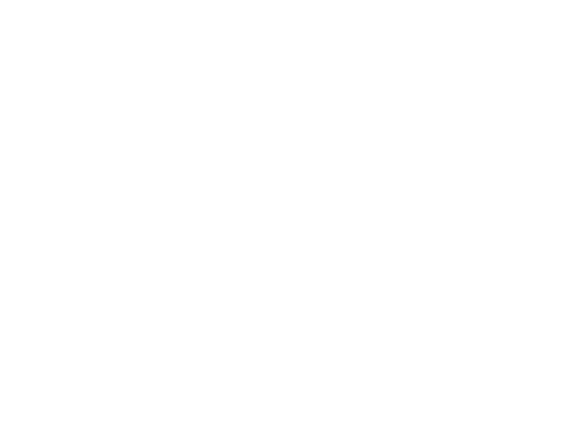

In [12]:
pcolors = "r"
tcolors = "k"


fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_aspect("equal")
margin = 1.
plt.axis([-2, 2, -2, 2])
plt.grid()
ax.axis("off")
points = []

msize = 10. * (s.m / s.m.max())**(1./6.)
for i in range(nm):
    plc = len(pcolors)
    pc = pcolors[i%plc]
    tlc = len(tcolors)
    tc = tcolors[i%tlc]
    trail, = ax.plot([], [], "-"+tc)
    point, = ax.plot([], [], "o"+pc, markersize = msize[i])
    points.append(point)
    points.append(trail)

    
def init():
    for i in range(2 * nm):
        points[i].set_data([], [])
    return points 

def animate(i):
    s.solve(dt, nt)
    x, y = s.xy()
    for i in range(nm):
        points[2*i].set_data(x[i:i+1], y[i:i+1])
        xt, yt = s.trail(i)
        points[2*i+1].set_data(xt, yt)
    return points

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=800, interval=20, blit=True)


plt.close()
anim
#plt.show()